In [1]:
!pip install torch torchvision torchsummary
!pip install scipy 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

# PyTorch imports
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, Subset, DataLoader
from torchsummary import summary

/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load data from CIFAR-10 Dataset

You can find more info on the CIFAR-10 dataset here: https://www.cs.toronto.edu/~kriz/cifar.html
- 60,000 images that are 32x32, RGB
- 60,000 total images have been partitioned into a training set of 50,000 and a test set of 10,000
- 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship, truck

**Normalization of pixels:** $\rho'=\dfrac{\rho-μ}{σ}$
- Normalizing pixels to range [-1, 1] by using $μ=0.5$ and $σ=0.5$
- Done in `transforms.Normalize`
- Ensures all input images have same scale

**Load data:**
- Load training data from CIFAR10 (`trainloader`)
- Load test data from CIFAR10 (`testloader`)
- Loads the data into a folder called `data` in your Google Drive folder

**Batch:**
- A batch is the number of images the model will be trained on at a time before updating weights. In this case the batch size chosen was 4 (`batch_size` variable)
- Batches help reduce training time, and keeping batches small will ensure the model is still accurately trained.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

# This downloads the CIFAR10 dataset into Google Drive under a 'data' folder
trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                           download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# The 10 classes/labels for the CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualize images from CIFAR10

Unnormalize pixels: $\rho=\rho'\sigma + \mu$

This shows a random batch (4 images) from the training data along with their class labels

`images` variable is a tensor of shape (4, 3, 32, 32)
- Tensors are the same concept as NumPy arrays; they are n-dimensional structures
- First axis: 4 is the number of images in our batch
- Second axis: 3 is the number of channels in each image (RGB)
- Third and fourth axes: Images are 32x32

`labels` is a list of integers corresponding to the index of the label for each image in the batch (4)
- So if the label for an image is `i`, we can use `classes[i]` to obtain the actual class name (plane, car, bird, ...)

/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Images data shape: torch.Size([4, 3, 32, 32])
Label raw data: tensor([0, 0, 0, 0])

Example of training set batch:


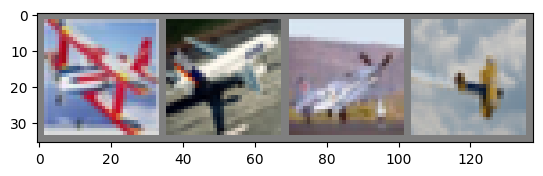

Actual Labels:  plane	plane	plane	plane


In [4]:
def imshow(img):
    # Unnormalize pixels
    img = img / 2 + 0.5
    npimg = img.numpy()
    # Put image into shape (32, 32, 3) to display
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random training image batch
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f'Images data shape: {images.shape}')
print(f'Label raw data: {labels}\n')

# Show images
print("Example of training set batch:")
imshow(utils.make_grid(images))
# Print labels
print('Actual Labels: ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Here is a summary of the layers (from input to output) that this CNN consists of:  
**Layer 1:** Convolutional layer (`self.conv1`)
- Input: 32x32x3 (RGB) image
- Performs convolution with 6 kernels (`out_channels` parameter) of size 5x5
- Output: 28x28x6 convolution output

**Layer 2:** Max pooling layer (`self.pool`)
- Input: 28x28x6 output from layer 1
- Subsamples each of the 6 results by taking the max element in 2x2 windows
- Output: 14x14x6 subsampled output

**Layer 3:** Convolutional layer (`self.conv2`)
- Input: 14x14x6 output from layer 2
- Performs convolution with 16 kernels (`out_channels` parameter) of size 5x5
- Output: 10x10x16 convolution output

**Layer 4:** Max pooling layer (`self.pool`)
- Input: 10x10x16 output from layer 3
- Output: 5x5x16 subsampled output

**Linear/Fully-connected layers:**
- The diagram above shows 2 fully connected (FC) layers (n1 and n2), but the code contains 3 as described here.
- `self.fc1` takes all 5x5x16 (400) pixels as input nodes and maps them to 120 output nodes
- `self.fc2` takes the 120 nodes as input and maps them to 84 output nodes
- Lastly, `self.fc3` takes the 84 nodes as input and outputs the final 10 nodes corresponding to each class/label for CIFAR10
  

In [5]:
# Don't change the code in this block

class SimpleCNN(nn.Module):
    '''Simple CNN neural network. See above description for what each layer does.'''

    def __init__(self):
        '''Defines each layer for SimpleCNN.'''
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        '''Defines graph of connections for each layer in SimpleCNN.'''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Loss Function and Gradient Descent

Here is more information about the implementation details. Most if this is background, as far as these Colab problems are concerned.

First, we attempt to use our computer's GPUs if we have any available. On free Google Colab instances, they won't be available, but if you are running this locally with an NVIDIA GPU, you should be able to enable CUDA to run and train the model on your GPU (although this is not necessary).

While this is almost necessary for most larger networks, our network is fairly simple and only takes 32x32 images as input, so training won't take too long on just a CPU.

**Loss Function:** The cross-entropy loss will be our loss function. The loss function is a function we want to minimize. Cross-entropy is a popular loss function for multi-class classification (we have 10 classes).
$$L = -Σ_i(t_i*log(p_i))$$
- The summation is going through each label ($i$) (plane, car, bird, ...).
- $t_i$ is the actual ground truth label we want our model to predict (it is equal to 1 for the true label, 0 for the other 9).
- $p_i$ is the predicted probability for each label from our model.
- Think of all the $p_i$ values as representing a probability distribution. This loss function will approach 0 when the computed distribution is about the same as the given set of $t_i$ values; and this loss function will be high when the computed distribution is wrong.
- More info on cross entropy loss can be found in section 5.1.3 of the textbook and also at this site: https://www.v7labs.com/blog/cross-entropy-loss-guide

**Gradient Descent:** This is the algorithm that updates the weights of our model, based on computing the gradient of $L$ with respect to the weights. We are using SGD (stochastic gradient descent), which just means that we update the weights after each batch. (This example will use a batch size of 4 images).
$$𝐖_{t+1} = 𝐖_t - α∇L$$
- 𝐖 is the set of all of the weights in our model, which we are updating by using this equation.
- α is the learning rate. A higher number will update our weight more substantially each iteration, while a lower number will  update them more slowly (`lr = 0.001` in this code).

In [6]:
device = "mps:0" if torch.cuda.is_available() else "cpu"  # Use GPU if possible
print(device)
simple_model = SimpleCNN().to(device)
summary(simple_model, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_model.parameters(), lr=0.001, momentum=0.9)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


## Training

This is the training loop for the network to actually learn the weights. This loop updates the weights by trying to minimize the loss function, which is eventually computed for all of the training images.

The training loop runs for a defined number of epochs, which is the number of times the model is trained on the entire set of training data (`trainloader`). The data is shuffled between each epoch.

Since we have set everything up, PyTorch does almost everything for us in this step. Here is what it does:

**Steps:**
1. Gets the input images and labels for the current batch (4 images at a time)
2. Gives the model the images, and it will predict the output labels
3. Calculates the loss function between ground truth and predicted labels
4. Calculates all gradients for backpropagation (`loss.backward()`)
5. Performs gradient descent to update the model weights (`optimizer.step()`)
6. Repeats on all images in the training set (50,000 images / 4 per batch = 12,500 iterations)
7. Repeats this for each epoch

In [10]:
# Don't change the code in this block

def train(model, loader, criterion, optimizer, epochs=2):
  '''Train a model from training data.

  Args:
    - model: Neural network to train
    - epochs: Number of epochs to train the model
    - loader: Dataloader to train the model with
  '''
  print('Start Training')

  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      total = 0
      correct = 0
      for i, data in enumerate(tqdm(loader)):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[epoch {epoch + 1}, batch {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

              print(f'\nAccuracy of the network on last 2000 training images: {100 * correct // total} %')
              total = 0
              correct = 0

  print('\nFinished Training')

### This will train our SimpleCNN.

- This will take some time, so be patient.
- It will train the SimpleCNN for 2 epochs, and will print out the average loss and the training accuracy for every 2000 batches.  
- Notice that every 2000 batches, the loss decreases and the training accuracy improves, this is how to tell if a model is correctly learning and improving throughout training.

In [14]:
# Train model on training data from CIFAR10
train(simple_model, trainloader, criterion, optimizer)

Start Training


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  9%|▉         | 1175/12500 [00:04<00:47, 240.78it/s]


KeyboardInterrupt: 

## View CNN Prediction

Here is an example of 4 images with their ground truth labels and with the predictions from our CNN model

/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


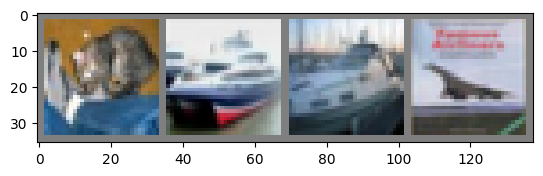

Ground Truth:    cat  	ship 	ship 	plane
CNN prediction:  bird 	bird 	bird 	bird 


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images from test set
imshow(utils.make_grid(images))
print('Ground Truth:   ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Input images into model and see ouptut
outputs = simple_model(images)
_, predicted = torch.max(outputs, 1)

print('CNN prediction: ', '\t'.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

## Testing our SimpleCNN Model

Now we will run our model on the test dataset (`testloader`) from CIFAR10. The model was not trained on this data, so we can measure the accuracy of our model (# correct / total) on this test set. The test dataset contains 10,000 images, which will be 2500 batches for us.

In [12]:
# Don't change the code in this block

def evaluation(model, loader):
  '''Evaluate a model and output its accuracy on a test dataset.

  Args:
    - model: Neural network to evaluate
    - loader: Dataloader containing test dataset
  '''
  # Evaluate accuracy on validation / test set
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in tqdm(loader):
          images, labels = data
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'\nAccuracy of the network on the 10000 test images: {100 * correct // total} %')

### Evaluate SimpleCNN
After running below, you'll see that the accuracy is much better than a random guess (which would be 10% since there are 10 classes), but it is still not perfect. (We got around 50% when running it).

This example shows the tradeoffs that are made when doing Machine Learning. Our model is simple and the input images are only 32x32x3, so the model trains fast and does not have many weights, but the accuracy is not amazing because of these choices. Typically, more complex models with more weights require GPUs to run, so this model was kept simple to avoid that need. However, later in this problem you will improve this network and increase the accuracy.

In [12]:
# Evaluate trained model on test dataset
evaluation(simple_model, testloader)

  0%|          | 0/2500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 2500/2500 [00:13<00:00, 182.13it/s] 


Accuracy of the network on the 10000 test images: 52 %


Save trained model so it can be loaded everytime you restart this Notebook, so you don't need to re-train it if you don't want to. Only run the cell below if your model was previously trained.

This step is optional, but useful if you plan to come back to this notebook and want to load your trained model without training it again.

In [13]:
# UNCOMMENT below if you want to save your trained model after training
# (only do this after your model finished training, so you can use it later if desired)
# ------------------------------------------------------------------------------------

SIMPLECNN_MODEL_PATH = './simplecnn_model.pth'
torch.save(simple_model.state_dict(), SIMPLECNN_MODEL_PATH)

Load saved model from before. Once again, this is optional.

In [14]:
# UNCOMMENT below if you want to load your saved trained model from before
# (only need to do this if you come back to this notebook and don't want to re-train the model again above)
# ------------------------------------------------------------------------------------

simple_model = SimpleCNN().to(device)
simple_model.load_state_dict(torch.load(SIMPLECNN_MODEL_PATH))

<All keys matched successfully>

## View SimpleCNN in Action

Run this cell as many times as you want to show a random batch from the test set, the model's predicted class, and the real class

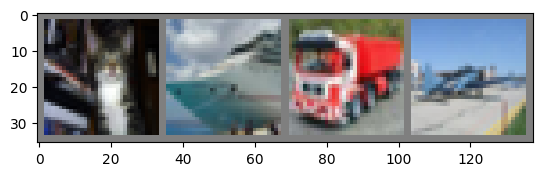

Ground Truth:    cat  	ship 	truck	plane
CNN prediction:  cat  	plane	truck	plane


In [226]:
# Random number between 1 and size of test set (9995 + batch_size (4))
random_idx = np.random.randint(9995)

images = []
labels = []
for i in range(random_idx, random_idx + batch_size):
  image, label = testset[i]
  images.append(image)
  labels.append(label)

image_tensors = torch.stack(images)

# print images from test set
imshow(utils.make_grid(image_tensors))
print('Ground Truth:   ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Input images into model and see ouptut
outputs = simple_model(image_tensors)
_, predicted = torch.max(outputs, 1)

print('CNN prediction: ', '\t'.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [151]:

class ChangedSimpleCNN(nn.Module):
    

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding = 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, padding=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=3)
        #self.dropout = nn.Dropout(p=0.5)
        
        #self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=128 * 5 * 5, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=512)
        # Your last layer should still be a linear layer with 10 out_features (for 10 output classes)
        self.fc3 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):

#        print('OG Size ',x.size())
        x = self.pool(F.relu(self.conv1(x)))
 #       print('Conv1 size',x.size())
        x = self.pool(F.relu(self.conv2(x)))
    #    print('Conv2 size',x.size())
        x = self.pool(F.relu(self.conv3(x)))
     #   print('Conv3 size',x.size())
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
      #  print('Flatten size',x.size())
        x = F.relu(self.fc1(x))
     #   print('Fc1 size',x.size())
      #  x = self.dropout(x)
      #  print("Dropout size", x.size())
        x = F.relu(self.fc2(x))
       # print('Fc2 size',x.size())
        x = self.fc3(x)
        #print('Fc3 size',x.size())
        return x

In [152]:
changed_model = ChangedSimpleCNN().to(device)
summary(changed_model, input_size=(3, 32, 32))


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(changed_model.parameters(), lr=0.0007, momentum=0.9)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 34, 34]           1,216
         MaxPool2d-2           [-1, 16, 17, 17]               0
            Conv2d-3           [-1, 64, 19, 19]          25,664
         MaxPool2d-4             [-1, 64, 9, 9]               0
            Conv2d-5          [-1, 128, 11, 11]         204,928
         MaxPool2d-6            [-1, 128, 5, 5]               0
            Linear-7                  [-1, 256]         819,456
            Linear-8                  [-1, 512]         131,584
            Linear-9                   [-1, 10]           5,130
Total params: 1,187,978
Trainable params: 1,187,978
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.54
Params size (MB): 4.53
Estimated Total Size (MB): 5.08
---------------------------------------

### Train ChangedSimpleCNN

In [153]:

epochs = 10
train(changed_model, trainloader, criterion, optimizer, epochs=epochs)

Start Training


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2029/12500 [00:16<01:11, 146.53it/s]

[epoch 1, batch  2000] loss: 2.271

Accuracy of the network on last 2000 training images: 14 %


 32%|███▏      | 4027/12500 [00:29<00:55, 153.83it/s]

[epoch 1, batch  4000] loss: 1.939

Accuracy of the network on last 2000 training images: 28 %


 48%|████▊     | 6026/12500 [00:42<00:42, 152.83it/s]

[epoch 1, batch  6000] loss: 1.734

Accuracy of the network on last 2000 training images: 35 %


 64%|██████▍   | 8026/12500 [00:56<00:29, 152.02it/s]

[epoch 1, batch  8000] loss: 1.584

Accuracy of the network on last 2000 training images: 41 %


 80%|████████  | 10022/12500 [01:09<00:15, 155.47it/s]

[epoch 1, batch 10000] loss: 1.482

Accuracy of the network on last 2000 training images: 45 %


 96%|█████████▌| 12027/12500 [01:23<00:03, 155.09it/s]

[epoch 1, batch 12000] loss: 1.412

Accuracy of the network on last 2000 training images: 49 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2018/12500 [00:16<01:09, 150.84it/s]

[epoch 2, batch  2000] loss: 1.313

Accuracy of the network on last 2000 training images: 53 %


 32%|███▏      | 4028/12500 [00:28<00:54, 156.88it/s]

[epoch 2, batch  4000] loss: 1.240

Accuracy of the network on last 2000 training images: 55 %


 48%|████▊     | 6020/12500 [00:41<00:41, 157.53it/s]

[epoch 2, batch  6000] loss: 1.164

Accuracy of the network on last 2000 training images: 58 %


 64%|██████▍   | 8022/12500 [00:54<00:28, 158.40it/s]

[epoch 2, batch  8000] loss: 1.135

Accuracy of the network on last 2000 training images: 59 %


 80%|████████  | 10023/12500 [01:06<00:15, 158.81it/s]

[epoch 2, batch 10000] loss: 1.073

Accuracy of the network on last 2000 training images: 61 %


 96%|█████████▌| 12014/12500 [01:19<00:03, 157.67it/s]

[epoch 2, batch 12000] loss: 1.056

Accuracy of the network on last 2000 training images: 63 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2019/12500 [00:16<01:15, 138.72it/s]

[epoch 3, batch  2000] loss: 0.931

Accuracy of the network on last 2000 training images: 67 %


 32%|███▏      | 4023/12500 [00:30<00:54, 156.40it/s]

[epoch 3, batch  4000] loss: 0.916

Accuracy of the network on last 2000 training images: 67 %


 48%|████▊     | 6025/12500 [00:43<00:41, 156.51it/s]

[epoch 3, batch  6000] loss: 0.889

Accuracy of the network on last 2000 training images: 69 %


 64%|██████▍   | 8030/12500 [00:55<00:28, 155.50it/s]

[epoch 3, batch  8000] loss: 0.860

Accuracy of the network on last 2000 training images: 70 %


 80%|████████  | 10031/12500 [01:08<00:15, 155.38it/s]

[epoch 3, batch 10000] loss: 0.879

Accuracy of the network on last 2000 training images: 69 %


 96%|█████████▌| 12017/12500 [01:21<00:03, 153.53it/s]

[epoch 3, batch 12000] loss: 0.855

Accuracy of the network on last 2000 training images: 69 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2030/12500 [00:16<01:08, 152.05it/s]

[epoch 4, batch  2000] loss: 0.720

Accuracy of the network on last 2000 training images: 74 %


 32%|███▏      | 4030/12500 [00:29<00:57, 148.56it/s]

[epoch 4, batch  4000] loss: 0.728

Accuracy of the network on last 2000 training images: 74 %


 48%|████▊     | 6027/12500 [00:42<00:42, 153.40it/s]

[epoch 4, batch  6000] loss: 0.733

Accuracy of the network on last 2000 training images: 74 %


 64%|██████▍   | 8025/12500 [00:55<00:29, 152.84it/s]

[epoch 4, batch  8000] loss: 0.717

Accuracy of the network on last 2000 training images: 74 %


 80%|████████  | 10026/12500 [01:08<00:16, 150.01it/s]

[epoch 4, batch 10000] loss: 0.726

Accuracy of the network on last 2000 training images: 73 %


 96%|█████████▌| 12026/12500 [01:21<00:03, 151.37it/s]

[epoch 4, batch 12000] loss: 0.707

Accuracy of the network on last 2000 training images: 75 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2015/12500 [00:16<01:09, 150.83it/s]

[epoch 5, batch  2000] loss: 0.559

Accuracy of the network on last 2000 training images: 80 %


 32%|███▏      | 4023/12500 [00:30<00:58, 145.43it/s]

[epoch 5, batch  4000] loss: 0.591

Accuracy of the network on last 2000 training images: 79 %


 48%|████▊     | 6021/12500 [00:43<00:42, 151.36it/s]

[epoch 5, batch  6000] loss: 0.593

Accuracy of the network on last 2000 training images: 79 %


 64%|██████▍   | 8018/12500 [00:56<00:29, 151.47it/s]

[epoch 5, batch  8000] loss: 0.599

Accuracy of the network on last 2000 training images: 78 %


 80%|████████  | 10023/12500 [01:09<00:16, 149.76it/s]

[epoch 5, batch 10000] loss: 0.623

Accuracy of the network on last 2000 training images: 78 %


 96%|█████████▌| 12020/12500 [01:23<00:03, 151.76it/s]

[epoch 5, batch 12000] loss: 0.586

Accuracy of the network on last 2000 training images: 79 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2030/12500 [00:17<01:08, 152.44it/s]

[epoch 6, batch  2000] loss: 0.433

Accuracy of the network on last 2000 training images: 85 %


 32%|███▏      | 4028/12500 [00:30<00:57, 148.61it/s]

[epoch 6, batch  4000] loss: 0.472

Accuracy of the network on last 2000 training images: 83 %


 48%|████▊     | 6026/12500 [00:43<00:42, 151.93it/s]

[epoch 6, batch  6000] loss: 0.471

Accuracy of the network on last 2000 training images: 83 %


 64%|██████▍   | 8015/12500 [00:56<00:29, 151.22it/s]

[epoch 6, batch  8000] loss: 0.495

Accuracy of the network on last 2000 training images: 81 %


 80%|████████  | 10015/12500 [01:09<00:16, 150.92it/s]

[epoch 6, batch 10000] loss: 0.489

Accuracy of the network on last 2000 training images: 82 %


 96%|█████████▌| 12020/12500 [01:22<00:03, 150.81it/s]

[epoch 6, batch 12000] loss: 0.493

Accuracy of the network on last 2000 training images: 82 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2030/12500 [00:16<01:07, 154.81it/s]

[epoch 7, batch  2000] loss: 0.325

Accuracy of the network on last 2000 training images: 88 %


 32%|███▏      | 4021/12500 [00:29<00:56, 149.06it/s]

[epoch 7, batch  4000] loss: 0.353

Accuracy of the network on last 2000 training images: 87 %


 48%|████▊     | 6014/12500 [00:41<00:48, 132.80it/s]

[epoch 7, batch  6000] loss: 0.383

Accuracy of the network on last 2000 training images: 86 %


 64%|██████▍   | 8026/12500 [00:54<00:29, 149.65it/s]

[epoch 7, batch  8000] loss: 0.402

Accuracy of the network on last 2000 training images: 85 %


 80%|████████  | 10014/12500 [01:07<00:15, 159.99it/s]

[epoch 7, batch 10000] loss: 0.408

Accuracy of the network on last 2000 training images: 85 %


 96%|█████████▌| 12017/12500 [01:19<00:03, 158.06it/s]

[epoch 7, batch 12000] loss: 0.405

Accuracy of the network on last 2000 training images: 85 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2017/12500 [00:16<01:08, 153.97it/s]

[epoch 8, batch  2000] loss: 0.251

Accuracy of the network on last 2000 training images: 90 %


 32%|███▏      | 4019/12500 [00:28<00:57, 147.84it/s]

[epoch 8, batch  4000] loss: 0.265

Accuracy of the network on last 2000 training images: 90 %


 48%|████▊     | 6020/12500 [00:41<00:41, 155.97it/s]

[epoch 8, batch  6000] loss: 0.287

Accuracy of the network on last 2000 training images: 89 %


 64%|██████▍   | 8023/12500 [00:54<00:28, 156.31it/s]

[epoch 8, batch  8000] loss: 0.305

Accuracy of the network on last 2000 training images: 89 %


 80%|████████  | 10026/12500 [01:06<00:16, 152.22it/s]

[epoch 8, batch 10000] loss: 0.328

Accuracy of the network on last 2000 training images: 88 %


 96%|█████████▌| 12020/12500 [01:19<00:03, 148.98it/s]

[epoch 8, batch 12000] loss: 0.323

Accuracy of the network on last 2000 training images: 88 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2019/12500 [00:16<01:08, 152.14it/s]

[epoch 9, batch  2000] loss: 0.183

Accuracy of the network on last 2000 training images: 93 %


 32%|███▏      | 4018/12500 [00:30<00:56, 151.30it/s]

[epoch 9, batch  4000] loss: 0.205

Accuracy of the network on last 2000 training images: 92 %


 48%|████▊     | 6018/12500 [00:43<00:42, 151.64it/s]

[epoch 9, batch  6000] loss: 0.226

Accuracy of the network on last 2000 training images: 91 %


 64%|██████▍   | 8030/12500 [00:56<00:29, 150.88it/s]

[epoch 9, batch  8000] loss: 0.253

Accuracy of the network on last 2000 training images: 90 %


 80%|████████  | 10017/12500 [01:09<00:16, 150.03it/s]

[epoch 9, batch 10000] loss: 0.271

Accuracy of the network on last 2000 training images: 90 %


 96%|█████████▌| 12030/12500 [01:23<00:03, 150.00it/s]

[epoch 9, batch 12000] loss: 0.273

Accuracy of the network on last 2000 training images: 90 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2026/12500 [00:16<01:12, 145.34it/s]

[epoch 10, batch  2000] loss: 0.138

Accuracy of the network on last 2000 training images: 95 %


 32%|███▏      | 4020/12500 [00:29<00:58, 144.72it/s]

[epoch 10, batch  4000] loss: 0.180

Accuracy of the network on last 2000 training images: 93 %


 48%|████▊     | 6028/12500 [00:42<00:42, 152.14it/s]

[epoch 10, batch  6000] loss: 0.183

Accuracy of the network on last 2000 training images: 93 %


 64%|██████▍   | 8026/12500 [00:55<00:28, 154.49it/s]

[epoch 10, batch  8000] loss: 0.204

Accuracy of the network on last 2000 training images: 92 %


 80%|████████  | 10015/12500 [01:07<00:16, 147.51it/s]

[epoch 10, batch 10000] loss: 0.206

Accuracy of the network on last 2000 training images: 92 %


 96%|█████████▌| 12016/12500 [01:21<00:03, 145.68it/s]

[epoch 10, batch 12000] loss: 0.229

Accuracy of the network on last 2000 training images: 91 %


100%|██████████| 12500/12500 [01:35<00:00, 131.42it/s]


Finished Training


### Evaluate ChangedSimpleCNN

In [154]:

evaluation(changed_model, testloader)

  0%|          | 0/2500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 2500/2500 [00:18<00:00, 134.54it/s]


Accuracy of the network on the 10000 test images: 73 %


## Implement Custom Conv2d Layer

In the previous problem, we used PyTorch's built-in `nn.Conv2d` layer, which is called the Convolutional Layer (Conv2d layer), and is the backbone of a CNN.

In this problem, you will make the Conv2d layer yourself.

###**Conv2d Quick Overview:**
- In short, the Conv2d layer performs convolution as you have learned in this course, but with several sets of kernels.
- As we train the network, it will learn what values to use in each kernel to correctly classify the images.
- Thus, the network essentially learns which filters work best (such as edge detectors) instead of us having to hand-pick them.



In order to implement the Conv2d layer yourself, you will need to understand how this layer works in-depth, and familiarize yourself with the size of the inputs and outputs of the layer.

For an in-depth breakdown of CNNs, see section 5.4 of the textbook, or skip to the Convolutional Layer section at this site: https://cs231n.github.io/convolutional-networks/
  - This resource mentions padding ($P$) and stride ($S$), but we will simplify our layer and not worry about these parameters.


To simplify parts of it, your Conv2d layer will only use stride 1 ($S=1$, normal convolution) and no padding ($P=0$).

###**Conv2d Breakdown:**
**Note:** *The rest of this notebook uses this notation, so you will most likely reference this a lot.*
- Input (shape $B*N*H_1*W_1$):
  - $B$: Batch size (number of images in this input)
  - $N$: Number of channels (depth) in input
  - $W_1$: Width of input image
  - $H_1$: Height of input image
- Kernels:
  - $F$: Kernel size, such that kernel width and height is $F*F$
- Output (shape $B*D*H_2*W_2$):
  - $B$: Batch size (need an output for each image in the batch)
  - $D$: Number of channels (depth) for output
    - This is equal to the number of kernels that will be convoled with the inputs
  - $W_2 = (W_1 - F) + 1$
    - Width of output image
  - Since we have square images, $H_2 = W_2$

In [91]:


from scipy import signal

class MyConv2dForward(torch.autograd.Function):




  @staticmethod
  
  
  def forward(x, kernels, bias):
    
    B, N, H1, W1 = x.size()
   # print("x shape",x.shape)
    K, K, _, D = kernels.size()
    
   # print("Kernel shape :",kernels.shape)
    _, H2, W2 = bias.size()
   
    
    output = torch.zeros((B,D,H2,W2))

    
    #print(output.shape)
   # for b in range(B):
    for b in range(B):
      for i in range(D):
        for j in range(N):
          output[b, i, :, :] += scipy.signal.correlate2d(x[b, j, :, :].numpy(), kernels[:,:,j,i].numpy(), mode="valid") 

        output[b, i, :, :] += bias[i, :, :]
        

        #print("Output shape now ", output.shape)
        #output[b][i] += bias[i] # Add bias term for each depth

    return output  
  
   

  

### Test your Conv2d `forward` pass:

In [92]:

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f'Input shape: {images.shape}')

# Sanity check of convolutional layer
kernels = torch.randn(5, 5, 3, 6)
bias = torch.randn(6, 28, 28)
out = MyConv2dForward.forward(images, kernels, bias)
print(f'Output shape: {out.shape}')



#Image size torch.Size([3, 32, 32])
#torch.Size([3, 6])

/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 6, 28, 28])


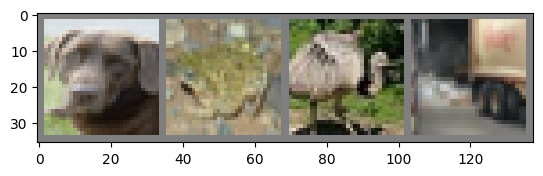

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images after filtering:


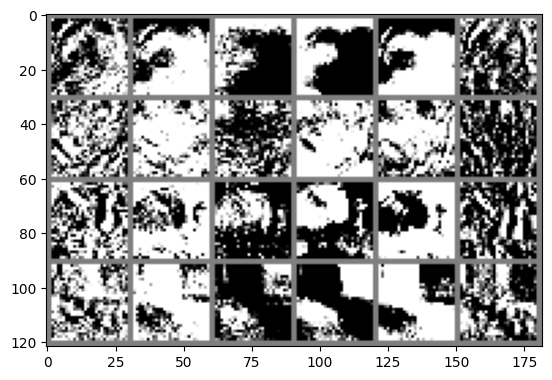

In [93]:
imshow(utils.make_grid(images))

# Visualize output images after filtering (in grayscale)
print('Images after filtering:')
out = out.reshape(out.shape[0]*out.shape[1], 1, out.shape[2], out.shape[3])
imshow(utils.make_grid(out, nrow=6))

# CHECK: The images after filtering should look as such if correct:
#   - Each row corresponds to a different image
#   - Each column is that image filtered with a different kernel

### In the code below, you will now implement the `backward` function for your Conv2d layer

To implement backpropagation for a neural network, the network needs the gradient of the loss function with respect to each input passed to the `forward` function. In the case of the Conv2d layer, we will be calculating this gradient for the kernels, input images, and bias.

Loss gradients you need to find with respect to each input variable:

\begin{equation}
\frac{\partial{L}}{\partial{X_i}}, \frac{\partial{L}}{\partial{B_i}}, \frac{\partial{L}}{\partial{K_{ij}}} \\
\text{known: }
\frac{\partial{L}}{\partial{Y_i}}
\end{equation}

In the above partial derivatives:
- $L$: loss function (error)
- $Y_i$: Output image from forward pass
- $X_i$: Input image to layer
- $B_i$: Bias parameters
- $K_{ij}$: Kernel parameters

The derivative of the loss function with respect to the output image ($Y_i$) is given by PyTorch as an input parameter to `backward` called `grad_output`, so we don't need to worry about finding this, treat it as an input.
- `grad_output` has shape ($B * D * H_2 * W_2$)

It is possible to derive these backpropagation partial derivatives (gradients) using the forward pass equation. The derivations are shown here (optional read): https://deeplearning.cs.cmu.edu/F21/document/recitation/Recitation5/CNN_Backprop_Recitation_5_F21.pdf

You will use these equations to calculate the gradients:
1. Gradient w.r.t. input image:
\begin{equation}
\frac{\partial{L}}{\partial{X_j}} = \sum_{i=1}^{D}\frac{\partial{L}}{\partial{Y_i}}*K_{ij} \\
for \space j = 1...\space{N}
\end{equation}
  - $*$ operator: Full convolution
    - see 'full' mode: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

2. Gradient w.r.t. kernel
\begin{equation}
\frac{\partial{L}}{\partial{K_{ij}}} = X_j \star \frac{\partial{L}}{\partial{Y_i}} \\
for \space i = 1...\space{D}, \space j = 1...\space{N}
\end{equation}
  - $\star$ operator: Valid cross-correlation (see link in `forward` section)

3. Gradient w.r.t. bias
\begin{equation}
\frac{\partial{L}}{\partial{B_i}} = \frac{\partial{L}}{\partial{Y_i}} \\
for \space i = 1...\space{D}
\end{equation}

**Hints:**
- You can use library functions to perform convolution and cross-correlation, such as `scipy.signal.correlate2d` and `scipy.signal.convolve2d`

In [96]:


class MyConv2d(MyConv2dForward):
  '''Full custom Conv2d functions with backpropogation.'''

  @staticmethod
  def setup_context(ctx, inputs, output):
    '''Save tensors for backward. Don't change this function.'''
    x, kernels, bias = inputs
    ctx.save_for_backward(x, kernels, bias)


  @staticmethod
  def backward(ctx, grad_output):
    x, kernels, bias = ctx.saved_tensors
    B, N ,_,_ = x.size()
    _,_,_,D = kernels.size()

    grad_x = torch.zeros_like(x)
   # print("Grad x shape ", grad_x.shape)
    grad_kernels = torch.zeros_like(kernels)
    grad_bias = torch.zeros_like(bias)
   # print("Grad out put shape ",grad_output.shape)
   # print("Kernel shape ", kernels.shape)
    for b in range(B):
      for i in range(D):
        for j in range(N):
          grad_x[b,j,:,:] += scipy.signal.convolve2d(grad_output[b,i,:,:].numpy(),kernels[:,:,j,i].numpy(), mode='full')
          grad_kernels[:,:,j,i] += scipy.signal.convolve2d(x[b,j,:,:].numpy(),grad_output[b,i,:,:].numpy(), mode='valid')
          grad_bias[i,:,:] += grad_output[b,i,:,:]
    return grad_x,grad_kernels,grad_bias


### Test `backward` function
- PyTorch has a function called `gradcheck` which will numerically check if your `backward` function has the correct gradient for your `forward` function.
- If done correctly, this cell should output `True`

In [97]:
# Check that gradients calculated in `backward` are correct
images.requires_grad = True
kernels.requires_grad = True
bias.requires_grad = True
image = images[0, 0, :16, :16]

bias = torch.randn(2, 15, 15)
kernels = torch.randn(2, 2, 1, 2)

test = torch.autograd.gradcheck(MyConv2d.apply, (image.reshape(1, 1, 16, 16), kernels, bias), eps=1e-3, atol=1e-2)
print(test)
# CHECK: should output True if forward and backward passes are correct

True


### In the code below, you will now implement the actual Conv2d custom layer.
- This `MyConv2dLayer` class will use the `MyConv2d` foward and backward functions you implemented above.
- In the constructor of this class, you will initialize the kernels and biases as the model parameters.

We will initialize our parameters the same way that the PyTorch `nn.Conv2d` layer does.
See the 'Variables:' section at the bottom for information: https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

From the above reference,
- Initialize the kernels with a Uniform Distribution (look into `np.random.uniform`) where the bounds are $(-\sqrt{k}, \sqrt{k})$.
  - where $k = \frac{1}{N*F*F}$

**Hints:**
- Since we want the kernels and biases to be learnable parameters for the model, they should be set as such:  
  - `self.kernels = nn.Parameter(...)`
  - `self.bias = nn.Parameter(...)`
- You are welcome to change the parameters to this `MyConv2dLayer` or which ones you use if you please. Just note you will have to change them in following code sections if you do.

In [99]:
class MyConv2dLayer(nn.Module):
  '''Custom Conv2d Layer, which calls MyConv2d in forward function with defined parameters to learn.'''

  def __init__(self, in_channels, out_channels, kernel_size, image_size):
    
    super().__init__()
    # TO DO: initialize self.kernels and self.bias
    self.kernels = nn.Parameter()
    k = 1.0 / (out_channels * kernel_size * kernel_size)
    self.kernels = nn.Parameter(torch.Tensor(kernel_size,kernel_size,in_channels,out_channels ))
    self.kernels.data.uniform_(-k**0.5, k**0.5)
    self.bias = nn.Parameter(torch.Tensor(out_channels,image_size[0]-kernel_size+1,image_size[1]-kernel_size + 1))
    self.bias.data.zero_()
    #print("bias shape : ",bias.shape)


  def forward(self, x):
    
    '''Forward for layer.

    Args:
      - x: Input to layer

    Output:
      - Output from layer after forward pass to pass to next layer
    '''

    return MyConv2d.apply(x, self.kernels, self.bias)

### Test MyConv2dLayer

In [100]:
# Test convolutional layer with N=3, D=6, F=5, with 32x32 input images
ConvTest = MyConv2dLayer(in_channels=3, out_channels=6, kernel_size=5, image_size=(32, 32))

# Get random training image batch
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f'Input shape: {images.shape}')

# Sanity check of convolutional layer
out = ConvTest(images)
kernels = torch.randn(5, 5, 3, 6)
print(f'Output shape: {out.shape}')

# CHECK: Output shape should be [4, 6, 28, 28]

/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 6, 28, 28])


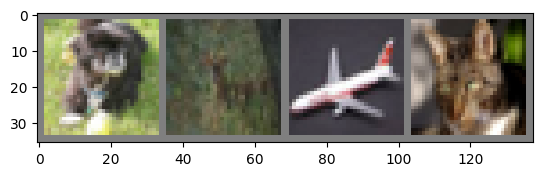

Images after filtering:


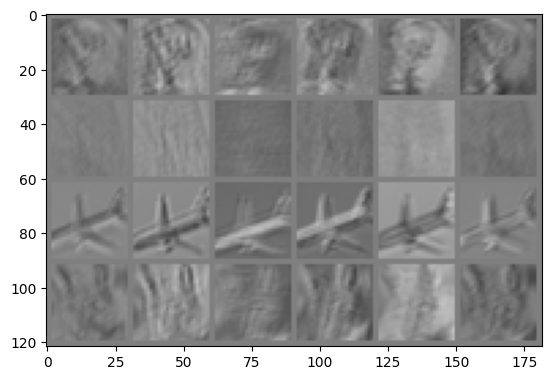

In [101]:
imshow(utils.make_grid(images))

# Visualize output images after filtering (in grayscale)
print('Images after filtering:')
out = out.reshape(out.shape[0]*out.shape[1], 1, out.shape[2], out.shape[3])
imshow(utils.make_grid(out, nrow=6))



PyTorch keeps a dictionary of all parameters that will be learned for the layer, so this code makes sure that your `kernels` and `bias` tensors were registered as model parameters.

In [102]:
print([p for p in ConvTest.named_parameters()])
# Ensure that 'kernels' and 'bias' are listed as parameters for this layer

[('kernels', Parameter containing:
tensor([[[[-0.0512, -0.0282, -0.0298,  0.0772, -0.0144,  0.0054],
          [-0.0291,  0.0265, -0.0138, -0.0209,  0.0086,  0.0640],
          [ 0.0364, -0.0021, -0.0100, -0.0630,  0.0161, -0.0427]],

         [[ 0.0323, -0.0742,  0.0404,  0.0497,  0.0726, -0.0235],
          [-0.0425, -0.0370, -0.0123,  0.0668,  0.0025, -0.0237],
          [ 0.0147, -0.0739,  0.0558, -0.0313, -0.0605, -0.0264]],

         [[-0.0427,  0.0754, -0.0298,  0.0329,  0.0500,  0.0474],
          [ 0.0615, -0.0396, -0.0444, -0.0108, -0.0708, -0.0236],
          [-0.0286, -0.0764,  0.0712,  0.0307, -0.0051,  0.0207]],

         [[ 0.0018,  0.0456,  0.0519, -0.0132, -0.0627,  0.0507],
          [-0.0132, -0.0262, -0.0332, -0.0791, -0.0762, -0.0788],
          [ 0.0409,  0.0721, -0.0607, -0.0638, -0.0171,  0.0636]],

         [[ 0.0466, -0.0650, -0.0197,  0.0267, -0.0582,  0.0153],
          [-0.0229,  0.0157,  0.0740,  0.0737,  0.0459, -0.0586],
          [ 0.0405, -0.0566,  0.0

## Training your CustomSimpleCNN network
- Now, your `MyConv2dLayer` can replace PyTorch's `nn.Conv2d` layer in the `SimpleCNN` network, which is done for you below
- We will train this network, and should see similar accuracy results for the trained `SimpleCNN` architecture

In [103]:
# No need to change anything here, unless you changed your MyConv2dLayer constructor parameters

class CustomSimpleCNN(nn.Module):
    '''CustomSimpleCNN uses your own custom Conv2d layer from this problem.'''

    def __init__(self):
        '''Defines layers for this network.'''
        super().__init__()

        self.conv1 = MyConv2dLayer(in_channels=3, out_channels=6, kernel_size=5, image_size=(32, 32))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = MyConv2dLayer(in_channels=6, out_channels=16, kernel_size=5, image_size=(14, 14))
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        '''Defines graph connections for layers of this network.'''

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [104]:
custom_model = CustomSimpleCNN().to(device)
summary(custom_model, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_model.parameters(), lr=0.001, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     MyConv2dLayer-1            [-1, 6, 28, 28]           4,704
         MaxPool2d-2            [-1, 6, 14, 14]               0
     MyConv2dLayer-3           [-1, 16, 10, 10]           1,600
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 65,438
Trainable params: 59,134
Non-trainable params: 6,304
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.25
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


### Optional Debug Loop
- The code below is commented out and not necessary to run, but will run training for 3 batches and allow you to print out some sample gradients being calculated for your model parameters (kernels and bias).
  - To verify the gradients, ensure that they are valid and change between loop iterations.
- You can uncomment this and use it to print anything during training to help debug your model if necessary.

In [ ]:
# UNCOMMENT if wanting to debug anything for a couple training iterations

# print('Training Debug Loop')

# for i, data in enumerate(tqdm(trainloader)):
#     # get the inputs; data is a list of [inputs, labels]
#     inputs, labels = data

#     # zero the parameter gradients
#     optimizer.zero_grad()

#     # forward + backward + optimize
#     outputs = custom_model(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()

#     if i == 3:
#       break

#     print('\n')
#     print(f'---------------------------------{i}---------------------------------')
#     print('KERNEL GRADIENTS:\n')
#     print(custom_model.conv1.kernels.grad[0, 0, :, :])
#     print('BIAS GRADIENTS:\n')
#     print(custom_model.conv1.bias.grad[0, :5, :5])

### Training CustomSimpleCNN
- This might take a while depending on your implementation's speed
- To debug quicker, check if the model accuracy increases between the first and second accuracy prints (batches 2000 and 4000).
  - If correct, your accuracy should improve between the first two outputs
- Without a fast, vectorized solution, this can take about 5 minutes per benchmark print (2000 batches)

In [105]:

train(custom_model, trainloader, criterion, optimizer)

Start Training


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2002/12500 [02:53<14:56, 11.71it/s]

[epoch 1, batch  2000] loss: 2.293

Accuracy of the network on last 2000 training images: 12 %


 32%|███▏      | 4002/12500 [05:45<12:06, 11.70it/s]

[epoch 1, batch  4000] loss: 2.100

Accuracy of the network on last 2000 training images: 21 %


 48%|████▊     | 6002/12500 [08:36<09:15, 11.69it/s]

[epoch 1, batch  6000] loss: 1.950

Accuracy of the network on last 2000 training images: 27 %


 64%|██████▍   | 8002/12500 [11:27<06:30, 11.52it/s]

[epoch 1, batch  8000] loss: 1.890

Accuracy of the network on last 2000 training images: 31 %


 80%|████████  | 10002/12500 [14:23<03:39, 11.40it/s]

[epoch 1, batch 10000] loss: 1.872

Accuracy of the network on last 2000 training images: 32 %


 96%|█████████▌| 12001/12500 [17:23<00:44, 11.29it/s]

[epoch 1, batch 12000] loss: 1.802

Accuracy of the network on last 2000 training images: 34 %


  0%|          | 0/12500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 16%|█▌        | 2001/12500 [03:00<14:59, 11.67it/s]

[epoch 2, batch  2000] loss: 1.758

Accuracy of the network on last 2000 training images: 35 %


 32%|███▏      | 4001/12500 [05:51<12:06, 11.70it/s]

[epoch 2, batch  4000] loss: 1.711

Accuracy of the network on last 2000 training images: 38 %


 48%|████▊     | 6001/12500 [08:44<10:13, 10.59it/s]

[epoch 2, batch  6000] loss: 1.710

Accuracy of the network on last 2000 training images: 38 %


 64%|██████▍   | 8001/12500 [11:38<06:24, 11.69it/s]

[epoch 2, batch  8000] loss: 1.688

Accuracy of the network on last 2000 training images: 38 %


 80%|████████  | 10001/12500 [14:32<03:41, 11.29it/s]

[epoch 2, batch 10000] loss: 1.680

Accuracy of the network on last 2000 training images: 39 %


 96%|█████████▌| 12002/12500 [17:32<00:43, 11.47it/s]

[epoch 2, batch 12000] loss: 1.657

Accuracy of the network on last 2000 training images: 40 %


100%|██████████| 12500/12500 [18:25<00:00, 11.30it/s]


Finished Training


### Evaluating CustomSimpleCNN
- If your Conv2d layer is correct, you should get an accuracy similar to that from the trained SimpleCNN provided in Problem 3, which was around 50% for us.

In [106]:

evaluation(custom_model, testloader)

  0%|          | 0/2500 [00:00<?, ?it/s]/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sathya/Desktop/CV_HW5/hwEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 2500/2500 [01:21<00:00, 30.76it/s]


Accuracy of the network on the 10000 test images: 42 %
